# Logistic Regression and Clustering Analysis on Employee Dataset

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')


## Load Employee Dataset

In [2]:

df = pd.read_csv("employee.csv")
df.head()


,id,timestamp,country,education_level,job_title,years_experience,salary
0,1,2022-01-31,USA,Bachelor,Engineer,1,60000
1,2,2022-02-28,USA,Master,Analyst,3,70000
2,3,2022-03-31,USA,PhD,Scientist,5,120000
3,4,2022-04-30,USA,Bachelor,Manager,2,90000
4,5,2022-05-31,USA,Master,Engineer,6,130000


## Preprocessing and Creating Binary Target

In [3]:

# Drop unnecessary columns
df = df.drop(columns=["id", "timestamp"])

# Create binary target: 1 if salary above median, else 0
median_salary = df["salary"].median()
df["high_salary"] = (df["salary"] > median_salary).astype(int)
df = df.drop(columns=["salary"])

# Split features and target
X = df.drop(columns="high_salary")
y = df["high_salary"]

# Define column types
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
])


## Logistic Regression with Different Thresholds

In [4]:

model = Pipeline([("preprocessor", preprocessor),
                  ("classifier", LogisticRegression(max_iter=1000))])

model.fit(X_train, y_train)
probs = model.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.1, 1.0, 0.1)
results = []

for t in thresholds:
    preds = (probs >= t).astype(int)
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    results.append([t, acc, prec, rec])

threshold_df = pd.DataFrame(results, columns=["Threshold", "Accuracy", "Precision", "Recall"])
threshold_df


,Threshold,Accuracy,Precision,Recall
0,0.1,0.5,0.5,1.0
1,0.2,0.5,0.5,1.0
2,0.3,0.5,0.5,1.0
3,0.4,1.0,1.0,1.0
4,0.5,1.0,1.0,1.0
5,0.6,0.5,0.0,0.0
6,0.7,0.5,0.0,0.0
7,0.8,0.5,0.0,0.0
8,0.9,0.5,0.0,0.0


## ROC Curve

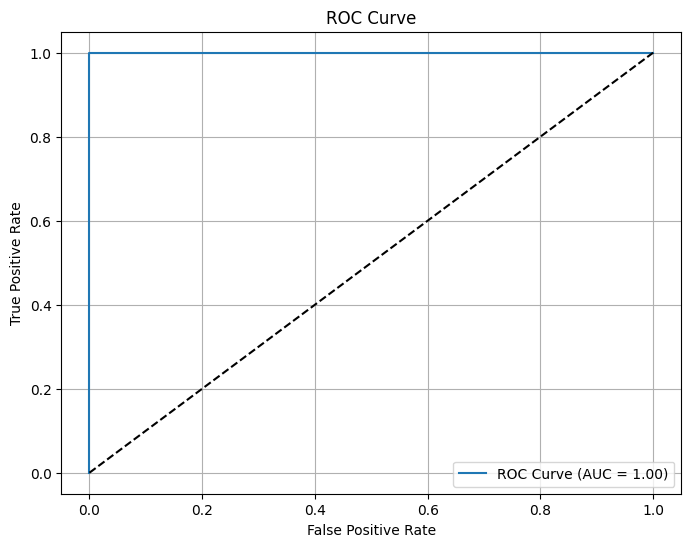

In [5]:

fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


## KMeans Clustering with Scaling

In [6]:

X_cluster = df.drop(columns="high_salary")
X_scaled = StandardScaler().fit_transform(pd.get_dummies(X_cluster))

inertias = []
silhouettes = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, kmeans.labels_))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, marker='o')
plt.title("Inertia vs K")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouettes, marker='o')
plt.title("Silhouette Score vs K")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.show()


ValueError: Number of labels is 10. Valid values are 2 to n_samples - 1 (inclusive)

## KMeans Clustering without Scaling

In [7]:

X_unscaled = pd.get_dummies(X_cluster)
inertias_ns = []
silhouettes_ns = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_unscaled)
    inertias_ns.append(kmeans.inertia_)
    silhouettes_ns.append(silhouette_score(X_unscaled, kmeans.labels_))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertias_ns, marker='o')
plt.title("Inertia without Scaling")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouettes_ns, marker='o')
plt.title("Silhouette Score without Scaling")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.show()


ValueError: Number of labels is 10. Valid values are 2 to n_samples - 1 (inclusive)